Imports.

In [31]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, UpSampling2D, \
                        ZeroPadding3D, Cropping2D, Conv2DTranspose
from keras.layers.merge import concatenate
import keras
from numba import njit

Definições, inicializações e funções utilitárias.

In [2]:
#The tolerance for floating pointer comparison
epsilon = 0.000001

#The complexity of the variogram models
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models
sill = 0.64

#The range for the longest structure allowed in the variogram models
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )    

Função gera superfície variográfica

In [3]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         yCell = gridParameters.Y0 + gridParameters.DY * j;
         x = (xCell - xc) * math.cos(theta[0]) - (yCell - yc) * math.sin(theta[0]);
         y = (xCell - xc) * math.sin(theta[0]) + (yCell - yc) * math.cos(theta[0]);
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Funções para gerar a superfície de um modelo variográfico de 4 estruturas

In [8]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;

#Does the same as makeVariogramModelSurface but it returs a volume eith each nested structure in a Z-slice
def makeVariogramModelStructures( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelStructures = np.zeros(( gridParameters.NI, gridParameters.NJ, numberOfNestedStructures ));
    for i in range( numberOfNestedStructures ) :
        variogramModelStructures[:,:,i] = \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelStructures;


Programa

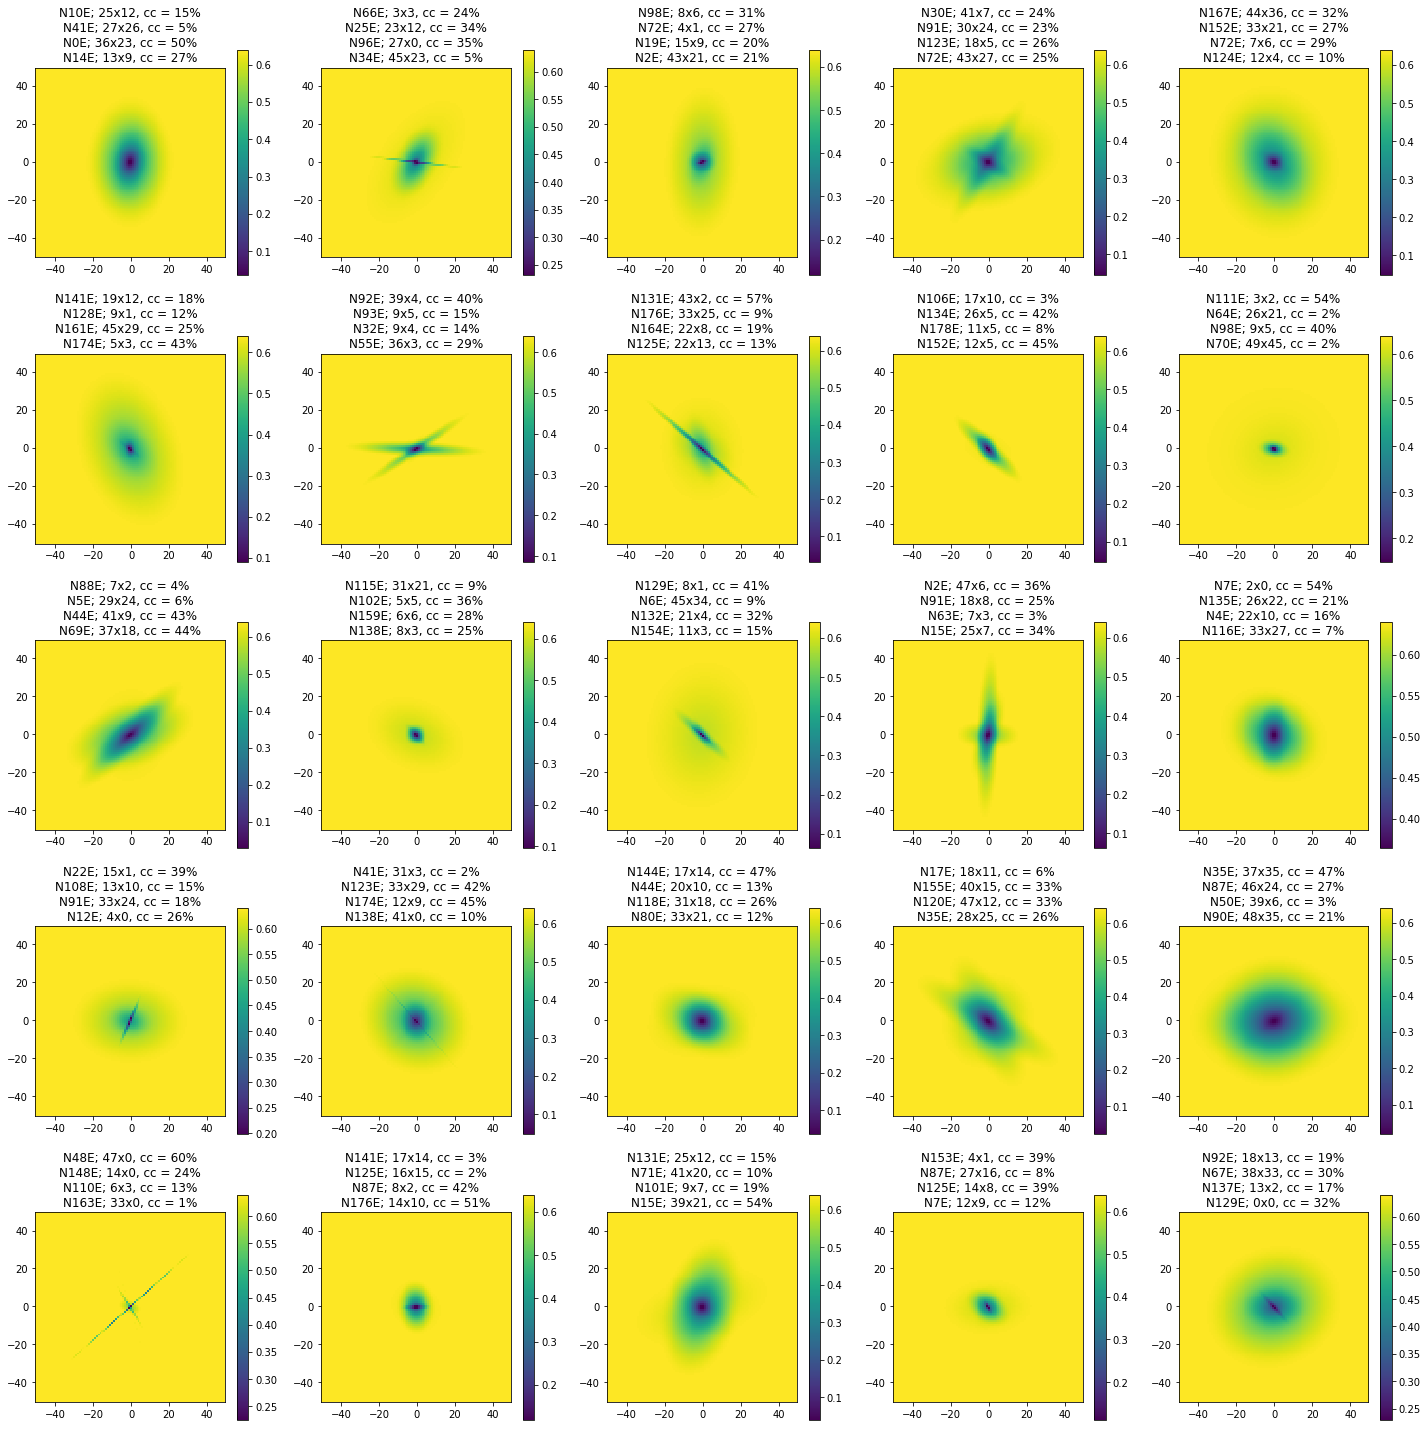

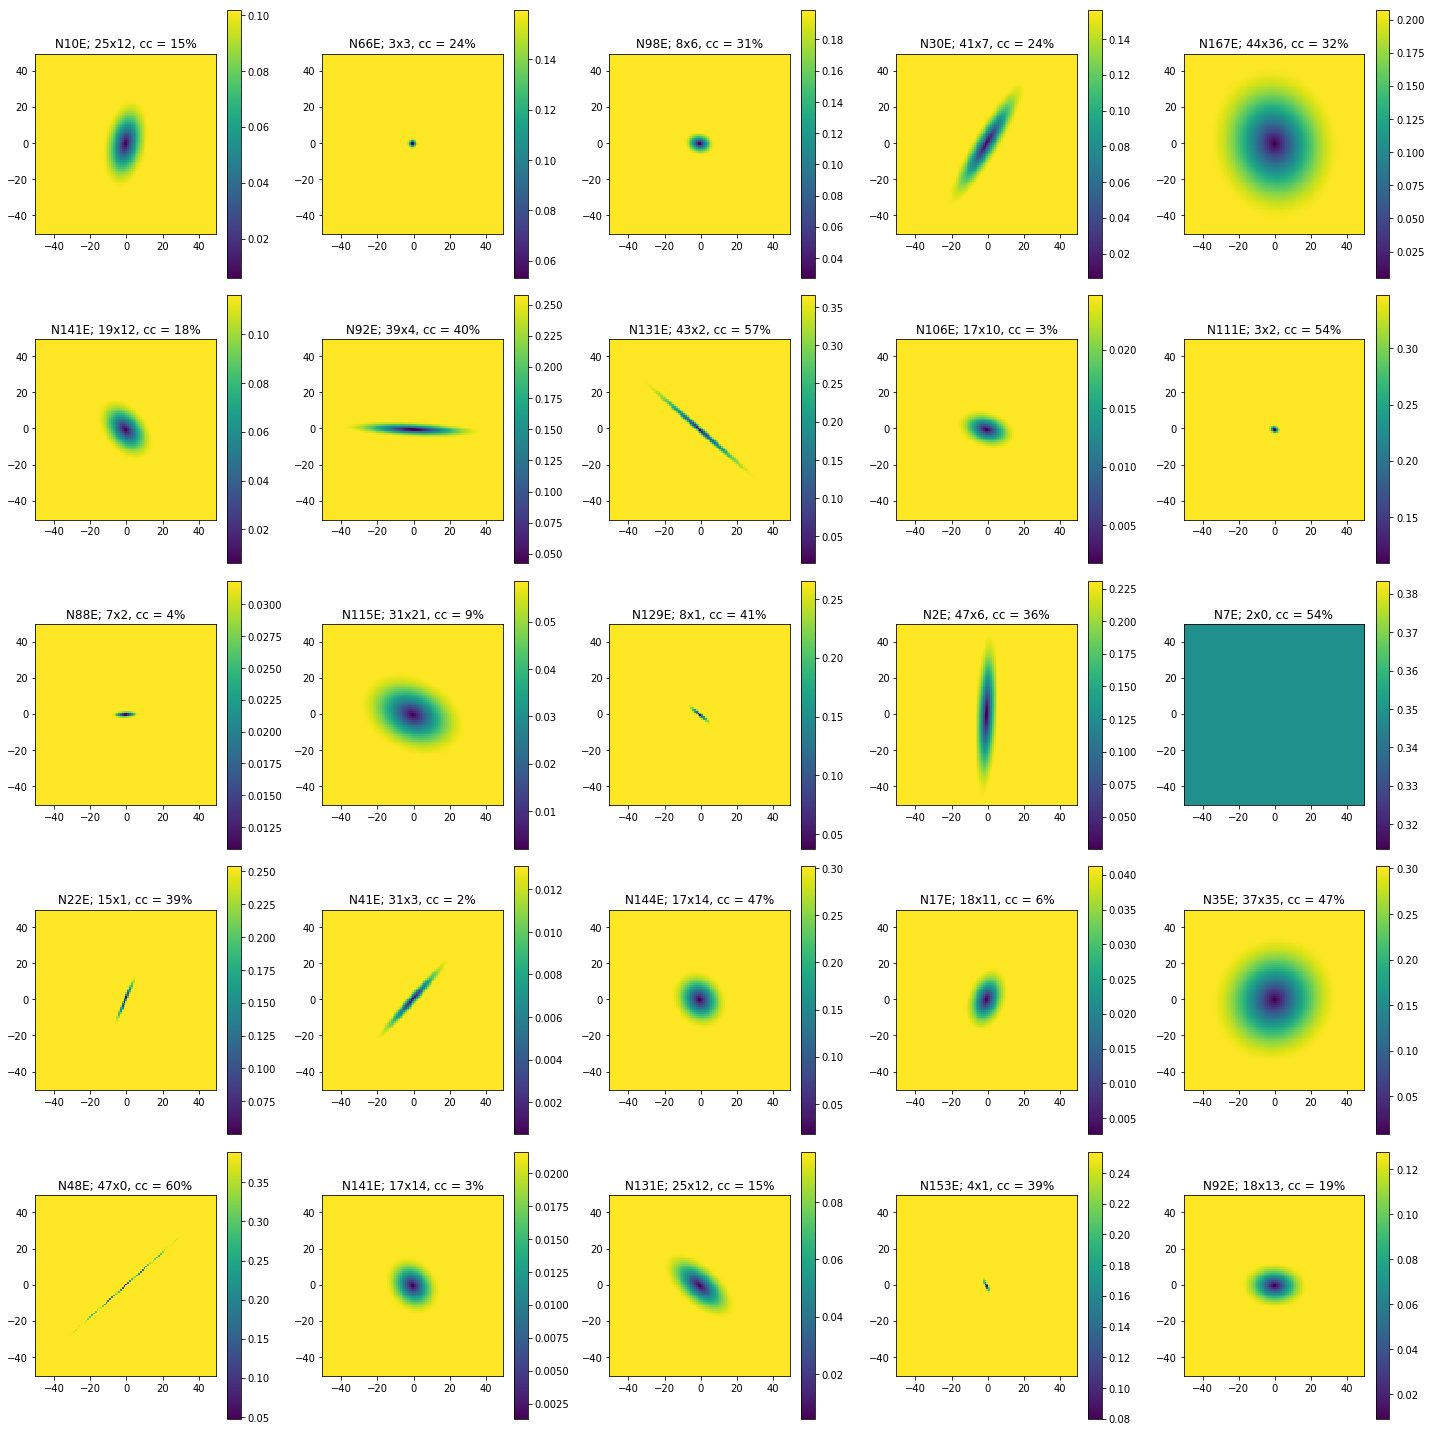

In [67]:
#The number of random variogram surfaces to generate
n = 40

#Allocate a volume for the stack of all variogram model surfaces n * 100 * 100 * 4
allVariograms = np.zeros(( n, getGridParameters().NI, getGridParameters().NJ, numberOfNestedStructures))

#Allocate a volume for the stack of all variogram model surfaces n * 100 * 100 * 4, but
#each nested strcuture is drawn in a different Z-slice
allVariogramsSeparated = np.zeros(( n, getGridParameters().NI, getGridParameters().NJ, numberOfNestedStructures))

#Allocate the stack of variographic parameters n * 16 * 1
allParameters = np.zeros(( n, totalNumberOfParameters, 1))

#Generate the variogram surfaces for training
for iVariogram in range(n):
    
    #Radomize the azimuths (N000E through N180E)
    az = np.random.rand(numberOfNestedStructures, 1)
    
    #Randomize the semi-major axes
    a = np.random.rand(numberOfNestedStructures, 1)

    #Randomize the semi-minor axes such that they are necessarily smaller than the semi-major axes
    b = np.multiply( a, np.random.rand(numberOfNestedStructures, 1) )
    
    #Randomize the contributions such that they sum up to a total (variogram sill)
    cc = np.random.rand(numberOfNestedStructures, 1) 
    cc = cc / np.sum(cc)
    #cc = np.full((numberOfNestedStructures, ), .25)
    
    #Linearize the array of variographic parameters
    linearArrayOfParametersUnitized = np.column_stack( (az, a, b, cc) ).reshape(totalNumberOfParameters,1)
    linearArrayOfParametersFullScale = np.column_stack( (az * 180, a*maxAxis, b*maxAxis, cc*sill) ).reshape(totalNumberOfParameters,1)
    
    #Make variogram surface
    variogramModelSurface = makeVariogramModelSurface( linearArrayOfParametersFullScale );
    
    #Stack the variogram surface
    for i in range(numberOfNestedStructures) :
       allVariograms[iVariogram,:,:,i] = variogramModelSurface

    #Make variogram structures in a single volum
    variogramModelStructures = makeVariogramModelStructures( linearArrayOfParametersFullScale );

    #Stack the volumes with the separated variogram structures in the z-slices
    allVariogramsSeparated[iVariogram,:,:] = variogramModelStructures
    
    #Stack the linearized variographic parameters
    allParameters[iVariogram,:,:] = linearArrayOfParametersUnitized


#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram surfaces to check data
iMap = int(0)
for ax in axs.flat:

    #plot the variogram surface
    mappable = ax.imshow( allVariograms[iMap,:,:,0], #the Z-slices of each volume are the same figure
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iMap,0,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,1,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,2,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,3,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,4,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,5,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,6,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,7,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,8,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,9,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,10,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,11,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,12,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,13,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,14,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,15,0])) + "%" )
    
    #Increment the synthetic map index/count
    iMap = iMap + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()

#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram n-nd structures to check data
iMap = int(0)
iStru = int(0)
for ax in axs.flat:

    #plot the variogram surface
    mappable = ax.imshow( allVariogramsSeparated[iMap,:,:,iStru], #the Z-slices of each volume are the same figure
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iMap,iStru*numberOfNestedStructures+0,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,iStru*numberOfNestedStructures+1,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,iStru*numberOfNestedStructures+2,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,iStru*numberOfNestedStructures+3,0])) + "%" )
    
    #Increment the synthetic map index/count
    iMap = iMap + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()


Carregar o mapa variográfico experimental

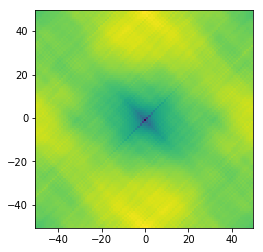

In [68]:
#Load the input experimental variogram map from teh GEO-EAS format (has some headers to skip)
experimentalVarmap = np.loadtxt(fname = "../GR_TESE_ML/value_Varmap.dat", skiprows=4)

#get the desired column (with the experimental semivariances)
experimentalVarmap = experimentalVarmap[:,0]

#reshape to 2D image
experimentalVarmap = experimentalVarmap.reshape(( getGridParameters().NI, getGridParameters().NJ ))

#stack the image n-times to match the neural network's input shape
tmp = np.zeros(( getGridParameters().NI, getGridParameters().NJ, numberOfNestedStructures ))
for i in range(numberOfNestedStructures) :
    tmp[:,:,i] = experimentalVarmap

experimentalVarmap = tmp

#plot the experimental varmap
plt.imshow( experimentalVarmap[:,:,0], interpolation='none', extent=getExtent2D( getGridParameters() ))

Parte de Machine Learning

In [69]:
#Normalizar os dados de entrada
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#ver se o normalizer traz para 0.0-1.0 mesmo
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainVariograms, testVariograms, trainVariogramsSeparated, testVariogramsSeparated = \
      train_test_split(allVariograms, allVariogramsSeparated, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os variogramas para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
#trainVariograms = trainVariograms.reshape(trainVariograms.shape + (1,)) #(1,) significa uma tupla de um elemento
#testVariograms  = testVariograms.reshape(testVariograms.shape + (1,))

#Cria a parte convolutiva da arquitetura de rede
input_layer = Input(shape=(getGridParameters().NI, getGridParameters().NJ, numberOfNestedStructures))
zp = ZeroPadding2D(padding=((14,14),(14,14))) ( input_layer ) 
conv1 = Conv2D(100, kernel_size=(3,3), activation='relu', padding='same') ( zp ) #camada convolutiva de 10 kernels (corresponde a 10 neurônios)
mp1 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv1 )
conv2 = Conv2D(200, kernel_size=3, activation='relu', padding='same') ( mp1 ) #camada convolutiva de 20 kernels (corresponde a 20 neurônios)
mp2 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv2 )
conv3 = Conv2D(400, kernel_size=3, activation='relu', padding='same') ( mp2 ) #camada convolutiva de 40 kernels (corresponde a 40 neurônios)
mp3 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv3 )
conv4 = Conv2D(800, kernel_size=3, activation='relu', padding='same') ( mp3 ) #camada convolutiva de 80 kernels (corresponde a 40 neurônios)
mp4 = MaxPooling2D(pool_size=(2, 2)) ( conv4 )
#conv5 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( mp4 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp5 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv5 )
#conv6 = Conv2D(320, kernel_size=3, activation='relu', padding='same') ( mp5 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp6 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv6 )
#conv7 = Conv2D(640, kernel_size=3, activation='relu', padding='same') ( mp6 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp7 = MaxPooling2D(pool_size=(2, 2)) ( conv7 )

#O eixo central da rede U
conv99 = Conv2D(1600, kernel_size=3, activation='relu', padding='same') ( mp4 ) #camada convolutiva de 80 kernels (corresponde a 80 neurônios)

#Cria a parte deconvolutiva da arquitetura de rede
#up7 = Conv2DTranspose(640, (3, 3), strides=(2, 2), padding='same') ( conv99 )
#up7 = concatenate([up7, conv7])  # <------------------------------------------informação vindo lá da camada conv.7
#dconv7 = Conv2D(640, kernel_size=3, activation='relu', padding='same') ( up7 )
#up6 = Conv2DTranspose(320, (3, 3), strides=(2, 2), padding='same') ( dconv7 )
#up6 = concatenate([up6, conv6])  # <------------------------------------------informação vindo lá da camada conv.6
#dconv6 = Conv2D(320, kernel_size=3, activation='relu', padding='same') ( up6 )
#up5 = Conv2DTranspose(160, (3, 3), strides=(2, 2), padding='same') ( dconv6 )
#up5 = concatenate([up5, conv5])  # <------------------------------------------informação vindo lá da camada conv.5
#dconv5 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( up5 )
up4 = Conv2DTranspose(800, (3, 3), strides=(2, 2), padding='same') ( conv99 )
up4 = concatenate([up4, conv4])  # <------------------------------------------informação vindo lá da camada conv.4
dconv4 = Conv2D(800, kernel_size=3, activation='relu', padding='same') ( up4 )
up3 = Conv2DTranspose(400, (3, 3), strides=(2, 2), padding='same') ( dconv4 )
up3 = concatenate([up3, conv3])  # <------------------------------------------informação vindo lá da camada conv.3
dconv3 = Conv2D(400, kernel_size=3, activation='relu', padding='same') ( up3 )
up2 = Conv2DTranspose(200, (3, 3), strides=(2, 2), padding='same') ( dconv3 )
up2 = concatenate([up2, conv2])  # <------------------------------------------informação vindo lá da camada conv.2
dconv2 = Conv2D(200, kernel_size=3, activation='relu', padding='same') ( up2 )
up1 = Conv2DTranspose(100, (3, 3), strides=(2, 2), padding='same') ( dconv2 )
up1 = concatenate([up1, conv1])  # <------------------------------------------informação vindo lá da camada conv.1
dconv1 = Conv2D(100, kernel_size=3, activation='relu', padding='same') ( up1 )

decoder = Conv2D(numberOfNestedStructures, kernel_size=3, activation='sigmoid', padding='same') ( dconv1 ) 
decoder = Cropping2D(cropping=((14,14),(14,14))) ( decoder )

#Monta a arquitetura autoencoder U completa
autoencoder = Model(input_layer, decoder)

#Mostra o resumo da arquitetura
autoencoder.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 100, 100, 4)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 128, 128, 4)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 128, 128, 100 3700        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 64, 64, 100)  0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_50 

In [70]:
#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #metrics=["accuracy"] não ajuda para regressões
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error') #metrics=["accuracy"] não ajuda para regressões

#treina a rede
#25% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
#Em uma rede autoencoder, tanto entradas quanto as saídas são imagens de mesma dimensão.
autoencoder.fit(trainVariograms, trainVariogramsSeparated,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(testVariograms, testVariogramsSeparated))


Train on 30 samples, validate on 10 samples
Epoch 1/20
30/30 [==============================] - 28s 917ms/step - loss: 0.1206 - val_loss: 0.0889
Epoch 2/20
30/30 [==============================] - 28s 928ms/step - loss: 0.0873 - val_loss: 0.0560
Epoch 3/20
30/30 [==============================] - 28s 949ms/step - loss: 0.0549 - val_loss: 0.0249
Epoch 4/20
30/30 [==============================] - 28s 937ms/step - loss: 0.0234 - val_loss: 0.0130
Epoch 5/20
30/30 [==============================] - 28s 938ms/step - loss: 0.0104 - val_loss: 0.0121
Epoch 6/20
30/30 [==============================] - 29s 959ms/step - loss: 0.0087 - val_loss: 0.0122
Epoch 7/20
30/30 [==============================] - 29s 981ms/step - loss: 0.0085 - val_loss: 0.0124
Epoch 8/20
30/30 [==============================] - 40s 1s/step - loss: 0.0084 - val_loss: 0.0125
Epoch 9/20
30/30 [==============================] - 41s 1s/step - loss: 0.0084 - val_loss: 0.0126
Epoch 10/20
30/30 [==============================] - 

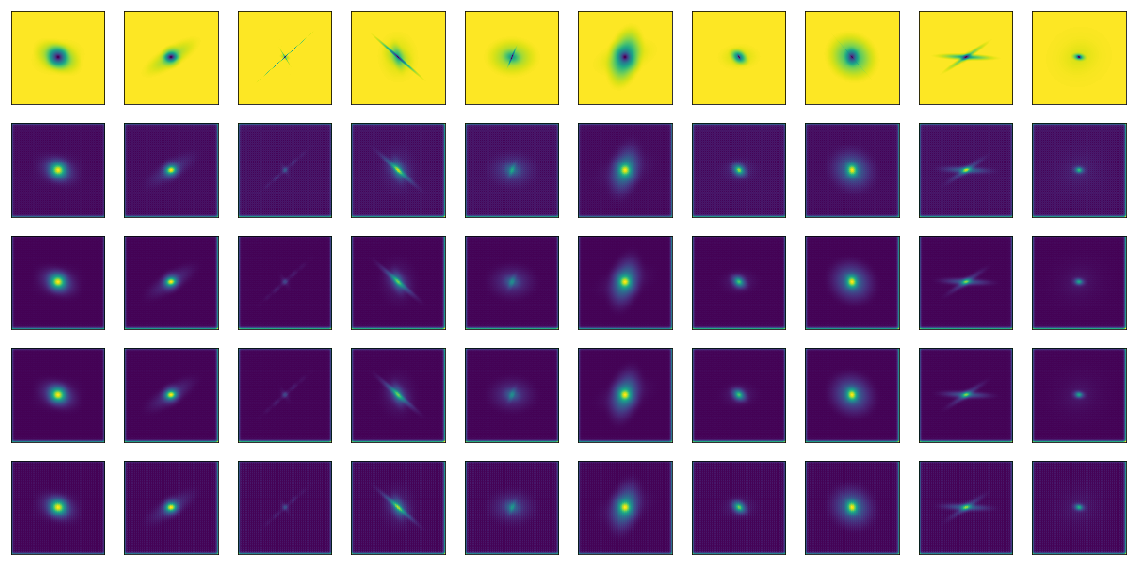

In [71]:
#teste a predição com os variogramas de teste
decoded_imgs = autoencoder.predict( testVariograms )

nFigs = 10
plt.figure(figsize=(20, 10))
for i in range(nFigs):
    # display original
    ax = plt.subplot(5, nFigs, i+1)
    plt.imshow(testVariograms[i,:,:,0].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,0].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 2*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,1].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 3*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,1].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 4*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,2].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()